In [1]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [2]:
root = './CIFAR10_Syn_Coreset'
ipc = 1000

### CIFAR10 Coreset

In [3]:
class CIFAR10_Coreset(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, label

In [4]:
index_file = pd.read_csv(f'./coreset_index_cifar10/ipc{ipc}_idx.csv')
index_file

,image_path,label
0,./CIFAR10_Syn_Coreset/ipc1000/airplane/0012acd...,0
1,./CIFAR10_Syn_Coreset/ipc1000/airplane/00be941...,0
2,./CIFAR10_Syn_Coreset/ipc1000/airplane/010447d...,0
3,./CIFAR10_Syn_Coreset/ipc1000/airplane/0138a7f...,0
4,./CIFAR10_Syn_Coreset/ipc1000/airplane/015c5a7...,0
...,...,...
9995,./CIFAR10_Syn_Coreset/ipc1000/truck/fef906d4-e...,9
9996,./CIFAR10_Syn_Coreset/ipc1000/truck/ff6b0ba8-1...,9
9997,./CIFAR10_Syn_Coreset/ipc1000/truck/ff8b88c4-7...,9
9998,./CIFAR10_Syn_Coreset/ipc1000/truck/ff95c441-6...,9


In [5]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar10_coreset_train = CIFAR10_Coreset(index_file, transform)

cifar10_root = '../cifar10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

In [6]:
batch_size = 64 
train_data_loader, test_data_loader = get_data_loaders(cifar10_coreset_train, cifar10_test, batch_size=batch_size)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


In [8]:
import os

model_name = 'ConvNetD3'
model_path = f'./model_weight/ipc{ipc}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=10, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [9]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=100)

Epoch 1: 100%|██████████| 157/157 [00:08<00:00, 18.17it/s, loss=0.0425]


epoch: 1 done, loss: 0.009330798871815205
Acc: 0.4314
[0.001]


Epoch 2: 100%|██████████| 157/157 [00:06<00:00, 24.12it/s, loss=0.0509]


epoch: 2 done, loss: 0.0017624404281377792
Acc: 0.482
[0.001]


Epoch 3: 100%|██████████| 157/157 [00:05<00:00, 27.86it/s, loss=0.0427]


epoch: 3 done, loss: 0.000910916889552027
Acc: 0.4965
[0.001]


Epoch 4: 100%|██████████| 157/157 [00:05<00:00, 27.09it/s, loss=0.0333] 


epoch: 4 done, loss: 0.0006109944661147892
Acc: 0.4988
[0.001]


Epoch 5: 100%|██████████| 157/157 [00:05<00:00, 26.75it/s, loss=0.00902]


epoch: 5 done, loss: 0.0004561712557915598
Acc: 0.5038
[0.001]


Epoch 6: 100%|██████████| 157/157 [00:06<00:00, 25.72it/s, loss=0.00478]


epoch: 6 done, loss: 0.00036962240119464695
Acc: 0.5225
[0.0001]


Epoch 7: 100%|██████████| 157/157 [00:06<00:00, 25.84it/s, loss=0.00576]


epoch: 7 done, loss: 0.00019533817248884588
Acc: 0.533
[0.0001]


Epoch 8: 100%|██████████| 157/157 [00:06<00:00, 25.53it/s, loss=0.0105] 


epoch: 8 done, loss: 0.00014222557365428656
Acc: 0.5339
[0.0001]


Epoch 9: 100%|██████████| 157/157 [00:06<00:00, 25.86it/s, loss=0.00489]


epoch: 9 done, loss: 0.00013452443818096071
Acc: 0.5368
[0.0001]


Epoch 10: 100%|██████████| 157/157 [00:06<00:00, 25.07it/s, loss=0.00374] 


epoch: 10 done, loss: 0.00011192546662641689
Acc: 0.5354
[1e-05]


Epoch 11: 100%|██████████| 157/157 [00:06<00:00, 25.03it/s, loss=0.00616]


epoch: 11 done, loss: 0.00010109136928804219
Acc: 0.5353
[1e-05]


Epoch 12: 100%|██████████| 157/157 [00:06<00:00, 24.99it/s, loss=0.00548]


epoch: 12 done, loss: 0.00010830102837644517
Acc: 0.5356
[1e-05]


Epoch 13: 100%|██████████| 157/157 [00:06<00:00, 25.59it/s, loss=0.00211]


epoch: 13 done, loss: 0.00010365737398387864
Acc: 0.5366
[1e-05]


Epoch 14: 100%|██████████| 157/157 [00:06<00:00, 25.00it/s, loss=0.00763]


epoch: 14 done, loss: 0.0001110639568651095
Acc: 0.5369
[1.0000000000000002e-06]


Epoch 15: 100%|██████████| 157/157 [00:06<00:00, 25.30it/s, loss=0.0056] 


epoch: 15 done, loss: 9.975299326470122e-05
Acc: 0.5366
[1.0000000000000002e-06]


Epoch 16: 100%|██████████| 157/157 [00:06<00:00, 25.15it/s, loss=0.00322]


epoch: 16 done, loss: 0.00010178122465731576
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 17: 100%|██████████| 157/157 [00:06<00:00, 24.87it/s, loss=0.00683] 


epoch: 17 done, loss: 0.00010300414578523487
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 18: 100%|██████████| 157/157 [00:06<00:00, 25.83it/s, loss=0.00202]


epoch: 18 done, loss: 9.456723637413234e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 19: 100%|██████████| 157/157 [00:06<00:00, 25.48it/s, loss=0.00585]


epoch: 19 done, loss: 9.720011439640075e-05
Acc: 0.5368
[1.0000000000000002e-06]


Epoch 20: 100%|██████████| 157/157 [00:06<00:00, 25.43it/s, loss=0.00103]


epoch: 20 done, loss: 0.00010089830902870744
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 21: 100%|██████████| 157/157 [00:06<00:00, 25.02it/s, loss=0.00105]


epoch: 21 done, loss: 0.000103950165794231
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 22: 100%|██████████| 157/157 [00:06<00:00, 25.74it/s, loss=0.00203]


epoch: 22 done, loss: 0.00010500296048121527
Acc: 0.5369
[1.0000000000000002e-06]


Epoch 23: 100%|██████████| 157/157 [00:06<00:00, 25.35it/s, loss=0.00674]


epoch: 23 done, loss: 0.00010154211486224085
Acc: 0.5362
[1.0000000000000002e-06]


Epoch 24: 100%|██████████| 157/157 [00:06<00:00, 25.56it/s, loss=0.00868]


epoch: 24 done, loss: 0.00010375903366366401
Acc: 0.5359
[1.0000000000000002e-06]


Epoch 25: 100%|██████████| 157/157 [00:06<00:00, 25.40it/s, loss=0.00582]


epoch: 25 done, loss: 0.00010207882587565109
Acc: 0.5357
[1.0000000000000002e-06]


Epoch 26: 100%|██████████| 157/157 [00:06<00:00, 25.50it/s, loss=0.00514]


epoch: 26 done, loss: 0.00010127863788511604
Acc: 0.5356
[1.0000000000000002e-06]


Epoch 27: 100%|██████████| 157/157 [00:06<00:00, 25.70it/s, loss=0.00168]


epoch: 27 done, loss: 0.00010559026850387454
Acc: 0.5362
[1.0000000000000002e-06]


Epoch 28: 100%|██████████| 157/157 [00:06<00:00, 25.29it/s, loss=0.00197]


epoch: 28 done, loss: 0.00010096821642946452
Acc: 0.5362
[1.0000000000000002e-06]


Epoch 29: 100%|██████████| 157/157 [00:06<00:00, 25.41it/s, loss=0.00145]


epoch: 29 done, loss: 0.00010207004379481077
Acc: 0.5362
[1.0000000000000002e-06]


Epoch 30: 100%|██████████| 157/157 [00:06<00:00, 25.81it/s, loss=0.000476]


epoch: 30 done, loss: 9.484928887104616e-05
Acc: 0.5362
[1.0000000000000002e-06]


Epoch 31: 100%|██████████| 157/157 [00:06<00:00, 25.18it/s, loss=0.00218]


epoch: 31 done, loss: 0.00010021107300417498
Acc: 0.5363
[1.0000000000000002e-06]


Epoch 32: 100%|██████████| 157/157 [00:06<00:00, 25.60it/s, loss=0.00245]


epoch: 32 done, loss: 9.992667764890939e-05
Acc: 0.537
[1.0000000000000002e-06]


Epoch 33: 100%|██████████| 157/157 [00:06<00:00, 24.71it/s, loss=0.00633]


epoch: 33 done, loss: 0.00010091520380228758
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 34: 100%|██████████| 157/157 [00:06<00:00, 25.25it/s, loss=0.00455]


epoch: 34 done, loss: 0.00010068336268886924
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 35: 100%|██████████| 157/157 [00:06<00:00, 25.40it/s, loss=0.00262]


epoch: 35 done, loss: 0.0001006952952593565
Acc: 0.5362
[1.0000000000000002e-06]


Epoch 36: 100%|██████████| 157/157 [00:06<00:00, 25.18it/s, loss=0.0103] 


epoch: 36 done, loss: 9.975840657716617e-05
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 37: 100%|██████████| 157/157 [00:06<00:00, 25.44it/s, loss=0.0161] 


epoch: 37 done, loss: 0.00010261287388857454
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 38: 100%|██████████| 157/157 [00:06<00:00, 25.41it/s, loss=0.00322]


epoch: 38 done, loss: 9.808826871449128e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 39: 100%|██████████| 157/157 [00:06<00:00, 25.54it/s, loss=0.00105]


epoch: 39 done, loss: 0.00010039564222097397
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 40: 100%|██████████| 157/157 [00:05<00:00, 26.44it/s, loss=0.000779]


epoch: 40 done, loss: 0.00010597916843835264
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 41: 100%|██████████| 157/157 [00:05<00:00, 26.97it/s, loss=0.00186]


epoch: 41 done, loss: 0.0001003288125502877
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 42: 100%|██████████| 157/157 [00:05<00:00, 27.26it/s, loss=0.00237]


epoch: 42 done, loss: 9.773789497558028e-05
Acc: 0.5361
[1.0000000000000002e-06]


Epoch 43: 100%|██████████| 157/157 [00:05<00:00, 27.15it/s, loss=0.00779]


epoch: 43 done, loss: 9.772514749784023e-05
Acc: 0.5362
[1.0000000000000002e-06]


Epoch 44: 100%|██████████| 157/157 [00:05<00:00, 26.76it/s, loss=0.00225]


epoch: 44 done, loss: 9.600075281923637e-05
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 45: 100%|██████████| 157/157 [00:05<00:00, 27.80it/s, loss=0.00352]


epoch: 45 done, loss: 9.70107939792797e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 46: 100%|██████████| 157/157 [00:05<00:00, 26.76it/s, loss=0.18]   


epoch: 46 done, loss: 0.00011698737944243476
Acc: 0.5368
[1.0000000000000002e-06]


Epoch 47: 100%|██████████| 157/157 [00:05<00:00, 26.92it/s, loss=0.0112] 


epoch: 47 done, loss: 9.927994688041508e-05
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 48: 100%|██████████| 157/157 [00:05<00:00, 26.91it/s, loss=0.00146] 


epoch: 48 done, loss: 9.960267198039219e-05
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 49: 100%|██████████| 157/157 [00:05<00:00, 27.13it/s, loss=0.00213]


epoch: 49 done, loss: 9.591224807081744e-05
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 50: 100%|██████████| 157/157 [00:05<00:00, 27.29it/s, loss=0.00101]


epoch: 50 done, loss: 9.435367246624082e-05
Acc: 0.5366
[1.0000000000000002e-06]


Epoch 51: 100%|██████████| 157/157 [00:05<00:00, 27.57it/s, loss=0.0203] 


epoch: 51 done, loss: 9.40554091357626e-05
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 52: 100%|██████████| 157/157 [00:05<00:00, 26.83it/s, loss=0.0144] 


epoch: 52 done, loss: 9.41396938287653e-05
Acc: 0.5363
[1.0000000000000002e-06]


Epoch 53: 100%|██████████| 157/157 [00:05<00:00, 27.07it/s, loss=0.00164]


epoch: 53 done, loss: 9.414840315002948e-05
Acc: 0.5361
[1.0000000000000002e-06]


Epoch 54: 100%|██████████| 157/157 [00:05<00:00, 26.87it/s, loss=0.000738]


epoch: 54 done, loss: 9.89873442449607e-05
Acc: 0.5363
[1.0000000000000002e-06]


Epoch 55: 100%|██████████| 157/157 [00:05<00:00, 27.16it/s, loss=0.0243]  


epoch: 55 done, loss: 9.393368964083493e-05
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 56: 100%|██████████| 157/157 [00:05<00:00, 26.95it/s, loss=0.00293]


epoch: 56 done, loss: 9.517222497379407e-05
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 57: 100%|██████████| 157/157 [00:05<00:00, 27.14it/s, loss=0.00767]


epoch: 57 done, loss: 9.181864879792556e-05
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 58: 100%|██████████| 157/157 [00:05<00:00, 27.21it/s, loss=0.0018] 


epoch: 58 done, loss: 8.704009087523445e-05
Acc: 0.5361
[1.0000000000000002e-06]


Epoch 59: 100%|██████████| 157/157 [00:05<00:00, 27.25it/s, loss=0.013]  


epoch: 59 done, loss: 9.019399294629693e-05
Acc: 0.5361
[1.0000000000000002e-06]


Epoch 60: 100%|██████████| 157/157 [00:05<00:00, 26.79it/s, loss=0.0161] 


epoch: 60 done, loss: 8.923940185923129e-05
Acc: 0.5368
[1.0000000000000002e-06]


Epoch 61: 100%|██████████| 157/157 [00:05<00:00, 27.13it/s, loss=0.00138]


epoch: 61 done, loss: 9.015615069074556e-05
Acc: 0.5366
[1.0000000000000002e-06]


Epoch 62: 100%|██████████| 157/157 [00:05<00:00, 26.90it/s, loss=0.00637]


epoch: 62 done, loss: 9.150357072940096e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 63: 100%|██████████| 157/157 [00:05<00:00, 27.14it/s, loss=0.00347]


epoch: 63 done, loss: 9.955924906535074e-05
Acc: 0.5366
[1.0000000000000002e-06]


Epoch 64: 100%|██████████| 157/157 [00:05<00:00, 27.14it/s, loss=0.00543]


epoch: 64 done, loss: 9.950330422725528e-05
Acc: 0.5366
[1.0000000000000002e-06]


Epoch 65: 100%|██████████| 157/157 [00:05<00:00, 27.36it/s, loss=0.0615] 


epoch: 65 done, loss: 9.673858585301787e-05
Acc: 0.5366
[1.0000000000000002e-06]


Epoch 66: 100%|██████████| 157/157 [00:05<00:00, 27.02it/s, loss=0.0147] 


epoch: 66 done, loss: 8.891441393643618e-05
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 67: 100%|██████████| 157/157 [00:05<00:00, 27.39it/s, loss=0.00369]


epoch: 67 done, loss: 8.910235919756815e-05
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 68: 100%|██████████| 157/157 [00:05<00:00, 27.47it/s, loss=0.00113]


epoch: 68 done, loss: 9.36762080527842e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 69: 100%|██████████| 157/157 [00:05<00:00, 27.73it/s, loss=0.00256]


epoch: 69 done, loss: 9.333134948974475e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 70: 100%|██████████| 157/157 [00:05<00:00, 27.60it/s, loss=0.0014] 


epoch: 70 done, loss: 9.336876246379688e-05
Acc: 0.5366
[1.0000000000000002e-06]


Epoch 71: 100%|██████████| 157/157 [00:05<00:00, 27.38it/s, loss=0.00322]


epoch: 71 done, loss: 9.455404506297782e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 72: 100%|██████████| 157/157 [00:05<00:00, 27.21it/s, loss=0.00269]


epoch: 72 done, loss: 9.362211858388036e-05
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 73: 100%|██████████| 157/157 [00:05<00:00, 27.79it/s, loss=0.00282]


epoch: 73 done, loss: 8.884186536306515e-05
Acc: 0.537
[1.0000000000000002e-06]


Epoch 74: 100%|██████████| 157/157 [00:05<00:00, 28.94it/s, loss=0.00152]


epoch: 74 done, loss: 9.274542389903218e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 75: 100%|██████████| 157/157 [00:04<00:00, 31.46it/s, loss=0.00358]


epoch: 75 done, loss: 8.960087870946154e-05
Acc: 0.5369
[1.0000000000000002e-06]


Epoch 76: 100%|██████████| 157/157 [00:05<00:00, 30.92it/s, loss=0.00512]


epoch: 76 done, loss: 9.253539610654116e-05
Acc: 0.537
[1.0000000000000002e-06]


Epoch 77: 100%|██████████| 157/157 [00:05<00:00, 31.26it/s, loss=0.00781]


epoch: 77 done, loss: 9.716301428852603e-05
Acc: 0.5371
[1.0000000000000002e-06]


Epoch 78: 100%|██████████| 157/157 [00:05<00:00, 31.37it/s, loss=0.00977]


epoch: 78 done, loss: 9.115308057516813e-05
Acc: 0.5369
[1.0000000000000002e-06]


Epoch 79: 100%|██████████| 157/157 [00:04<00:00, 31.53it/s, loss=0.00512]


epoch: 79 done, loss: 8.690980030223727e-05
Acc: 0.5368
[1.0000000000000002e-06]


Epoch 80: 100%|██████████| 157/157 [00:04<00:00, 31.55it/s, loss=0.00171]


epoch: 80 done, loss: 9.24432315514423e-05
Acc: 0.5368
[1.0000000000000002e-06]


Epoch 81: 100%|██████████| 157/157 [00:04<00:00, 31.43it/s, loss=0.0148] 


epoch: 81 done, loss: 9.828046313486993e-05
Acc: 0.5371
[1.0000000000000002e-06]


Epoch 82: 100%|██████████| 157/157 [00:05<00:00, 31.33it/s, loss=0.00118]


epoch: 82 done, loss: 9.549000969855115e-05
Acc: 0.5366
[1.0000000000000002e-06]


Epoch 83: 100%|██████████| 157/157 [00:04<00:00, 31.43it/s, loss=0.0157] 


epoch: 83 done, loss: 9.316494833910838e-05
Acc: 0.5364
[1.0000000000000002e-06]


Epoch 84: 100%|██████████| 157/157 [00:04<00:00, 32.04it/s, loss=0.0103] 


epoch: 84 done, loss: 8.939579856814817e-05
Acc: 0.5368
[1.0000000000000002e-06]


Epoch 85: 100%|██████████| 157/157 [00:04<00:00, 31.73it/s, loss=0.0102] 


epoch: 85 done, loss: 8.930355397751555e-05
Acc: 0.5365
[1.0000000000000002e-06]


Epoch 86: 100%|██████████| 157/157 [00:04<00:00, 31.81it/s, loss=0.00382]


epoch: 86 done, loss: 8.573184459237382e-05
Acc: 0.5362
[1.0000000000000002e-06]


Epoch 87: 100%|██████████| 157/157 [00:05<00:00, 31.21it/s, loss=0.00892]


epoch: 87 done, loss: 9.195221355184913e-05
Acc: 0.5363
[1.0000000000000002e-06]


Epoch 88: 100%|██████████| 157/157 [00:05<00:00, 30.67it/s, loss=0.0114] 


epoch: 88 done, loss: 9.581314225215465e-05
Acc: 0.5363
[1.0000000000000002e-06]


Epoch 89: 100%|██████████| 157/157 [00:05<00:00, 31.27it/s, loss=0.002]  


epoch: 89 done, loss: 9.033486276166514e-05
Acc: 0.5359
[1.0000000000000002e-06]


Epoch 90: 100%|██████████| 157/157 [00:05<00:00, 31.19it/s, loss=0.00243]


epoch: 90 done, loss: 8.874252671375871e-05
Acc: 0.5363
[1.0000000000000002e-06]


Epoch 91: 100%|██████████| 157/157 [00:04<00:00, 31.45it/s, loss=0.00619]


epoch: 91 done, loss: 8.659143350087106e-05
Acc: 0.5363
[1.0000000000000002e-06]


Epoch 92: 100%|██████████| 157/157 [00:05<00:00, 31.22it/s, loss=0.00502]


epoch: 92 done, loss: 8.791339496383443e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 93: 100%|██████████| 157/157 [00:05<00:00, 31.15it/s, loss=0.028]  


epoch: 93 done, loss: 8.988831541500986e-05
Acc: 0.5367
[1.0000000000000002e-06]


Epoch 94: 100%|██████████| 157/157 [00:05<00:00, 31.35it/s, loss=0.00714]


epoch: 94 done, loss: 8.935979712987319e-05
Acc: 0.5369
[1.0000000000000002e-06]


Epoch 95: 100%|██████████| 157/157 [00:05<00:00, 31.37it/s, loss=0.0118] 


epoch: 95 done, loss: 8.551219798391685e-05
Acc: 0.5371
[1.0000000000000002e-06]


Epoch 96: 100%|██████████| 157/157 [00:04<00:00, 31.48it/s, loss=0.0013] 


epoch: 96 done, loss: 8.779270865488797e-05
Acc: 0.5369
[1.0000000000000002e-06]


Epoch 97: 100%|██████████| 157/157 [00:05<00:00, 31.28it/s, loss=0.00233]


epoch: 97 done, loss: 8.635223639430478e-05
Acc: 0.5371
[1.0000000000000002e-06]


Epoch 98: 100%|██████████| 157/157 [00:04<00:00, 31.49it/s, loss=0.000794]


epoch: 98 done, loss: 8.414216426899657e-05
Acc: 0.537
[1.0000000000000002e-06]


Epoch 99: 100%|██████████| 157/157 [00:05<00:00, 30.94it/s, loss=0.00528]


epoch: 99 done, loss: 9.08520378288813e-05
Acc: 0.537
[1.0000000000000002e-06]


Epoch 100: 100%|██████████| 157/157 [00:05<00:00, 31.03it/s, loss=0.00222]


epoch: 100 done, loss: 8.502448326908052e-05
Acc: 0.5368
[1.0000000000000002e-06]
Time taken: 757.84417 seconds


In [10]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.5371, tensor(0.0324, device='cuda:0'))

<AxesSubplot: >

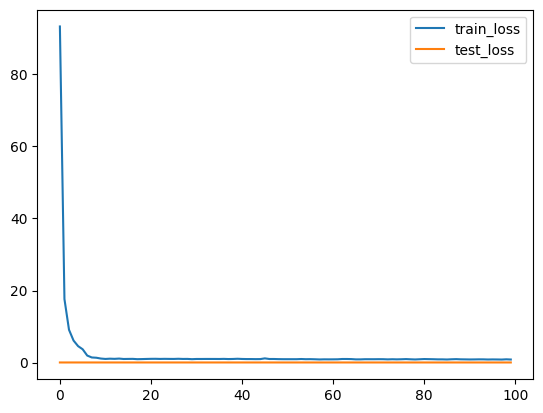

In [11]:

results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])